Connected to ihd-env (Python 3.11.9)

U-component Mean: -3.601599e-09
U-component Variance: 9.958927646872093e-05
U-component Integral: 1.0


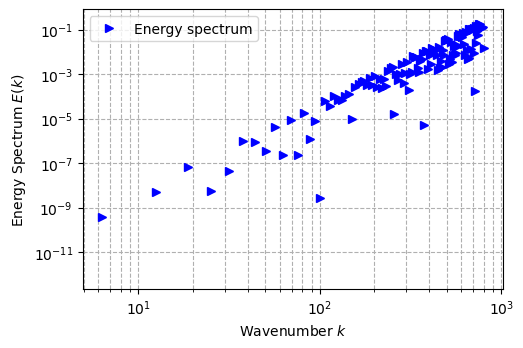

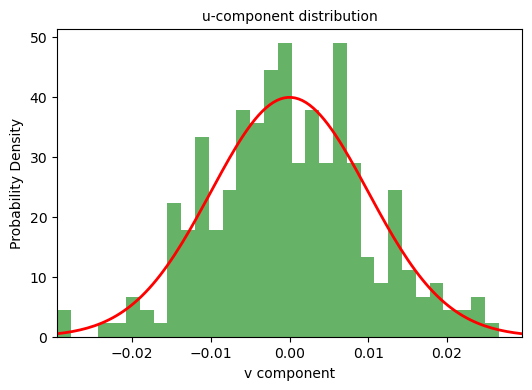

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from matplotlib import cm
import cv2
import torch as t

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


def compute_kolmogorov_spectrum(u, Lx):
    """
    Compute and plot the Kolmogorov spectrum using the straightforward energy spectrum calculation.

    Args:
        u: 2D array of x-velocity fluctuations.
        v: 2D array of y-velocity fluctuations.
        Lx: Length of the domain in the x-direction.
        Ly: Length of the domain in the y-direction.

    Returns:
        k: 1D array of wavenumbers.
        energy_spectrum: 1D array of energy spectrum values.
    """
    # Grid dimensions
    Nx = u.shape[0]

    # Compute the 2D Fourier transforms of the velocity fields
    u_hat = t.fft.fft(u)

    # Compute the energy spectrum as the sum of the squared magnitudes of the Fourier coefficients
    energy_spectrum = t.abs(u_hat)**2 

    # Average the energy spectrum over one dimension (e.g., the y-dimension)
    # energy_spectrum = t.mean(energy_spectrum, axis=0)

    # Corresponding wavenumbers
    kx = t.fft.fftfreq(Nx, d=Lx/Nx) * 2 * t.pi

    # Sort the spectrum by wavenumber
    idx = t.argsort(kx)
    k_sorted = kx[idx]
    energy_spectrum_sorted = energy_spectrum[idx]
    
    return kx, energy_spectrum

    # return k_sorted, energy_spectrum_sorted



class SpectralTurbulenceGenerator1D(t.nn.Module):
    def __init__(
            self,
            domain_size,
            grid_size, 
            turb_intensity, 
            noise_limiter=(-1E-3,1E-3),
            energy_spectrum=None, 
            frequency_range=None, 
            dt_turb=1E-4,
            device='cuda'
            ):
        """
        Initialize the TurbulenceGenerator with domain and grid parameters for 1D turbulence.
        
        Parameters:
        - domain_size: float, representing the size of the domain
        - grid_size: int, representing the number of grid points
        - turb_intensity: float, turbulence intensity scaling factor
        - energy_spectrum: function, energy spectrum function (optional)
        """
        self.Lx = domain_size
        self.Nx = grid_size
        self.desired_std = 1.0  # desired standard deviation of the output 
        self.turb_intensity = turb_intensity
        self.energy_spectrum = energy_spectrum if energy_spectrum else self.default_energy_spectrum.to(device)
        self.frequency_range = frequency_range if frequency_range else {'k_min': 2.0 * t.pi / domain_size, 'k_max': 2.0 * t.pi / (domain_size / 20)}

        # Fourier transform wave numbers
        self.kx = (t.fft.fftfreq(self.Nx, d=self.Lx/self.Nx) * 2 * t.pi).to(device)
        self.K = t.abs(self.kx).to(device)

        # Initialize the phase once and use it in each run
        self.phase_u = (t.rand(self.Nx) * 2 * t.pi).to(device)
        
        self.amplitude = (t.where(self.K != 0, (self.energy_spectrum(self.K)), 0)).to(device)
        self.amplitude = (t.where((self.K >= self.frequency_range['k_min']) & (self.K <= self.frequency_range['k_max']), self.amplitude, 0.0)).to(device)

        self.dt_turb = dt_turb
        self.omega = self.dt_turb * self.K
        
        self.noise_limiter = noise_limiter
        

    def default_energy_spectrum(self, k):
        """
        Default energy spectrum function based on Kolmogorov's -5/3 law.
        """
        with t.errstate(divide='ignore', invalid='ignore'):
            spectrum = k ** (-5.0 / 3.0)
            spectrum[t.isinf(spectrum)] = 0  # Replace any infinities (from divide by zero) with 0
        return spectrum

    def tanh_limiter(self, x, min_val, max_val, sharpness=1.0):
        """
        Applies a tanh-like limiter to smoothly constrain x within [min_val, max_val] with adjustable sharpness.
        """
        mid_val = (max_val + min_val) / 2
        range_val = (max_val - min_val) / 2
        # Adjusted tanh with sharpness
        return mid_val + range_val * t.tanh(sharpness * (x - mid_val) / range_val)

    def limit_velocity_field(self, u, min_val, max_val):
        """
        Limits the magnitude of a velocity field with the u component using a tanh-like limiter.
        """
        u_limited = self.tanh_limiter(u, min_val, max_val)
        return u_limited

    def generate_turbulence(self, time):
        """
        Generates 1D synthetic turbulence using a spectral method at a specific time.
        
        Parameters:
        - time: float, specific time at which to generate the turbulence
        
        Returns:
        - u: 1D array of x-velocity fluctuations (Nx,)
        """

        u_hat = self.turb_intensity * self.amplitude * t.exp(1j * (self.phase_u + self.omega * time))
        u = t.real(t.fft.ifft(u_hat))

        if self.turb_intensity < 1E-14:
            u = 0 * self.K  # Avoid division by 0 in t.std(u)
        else:
            # Normalize u to have a standard deviation of 1
            u /= t.std(u)
            u *= self.turb_intensity

        # Apply limiter
        min_noise, max_noise = self.noise_limiter
        u = self.limit_velocity_field(u, min_noise, max_noise)
        
        return u.float()  # equivalent of self.to(torch.float32)



def plot_v_component_distribution(v_data, title):
    # Ensure the data is a 1D array
    v_data = v_data.reshape(-1).cpu()  # Flatten the data

    num_bins = 32
    counts, bins = np.histogram(v_data, bins=num_bins, density=True) 

    bin_widths = np.diff(bins)
    integral = np.sum(counts * bin_widths)

    # Fit Gaussian distribution to the data
    mu, sigma = norm.fit(v_data)
    
    # Create an array over the full range specified
    x_range = np.linspace(-max(v_data.max(), -v_data.min()) * 2, max(v_data.max(), -v_data.min()) * 2, 256)
    gaussian_fit = norm.pdf(x_range, mu, sigma)

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(6, 4))  # Adjusted size for normal plot

    # Plot the histogram and Gaussian fit
    ax.hist(v_data, bins=num_bins, density=True, alpha=0.6, color='g')
    ax.set_xlim([-max(v_data.max(), -v_data.min()), max(v_data.max(), -v_data.min())])
    # ax.set_xlim(-1E-2, 1E-2)
    # ax.set_ylim(0, 1000)
    ax.plot(x_range, gaussian_fit, 'r-', lw=2)
    
    # Set plot titles and labels
    ax.set_title(f'{title}', fontsize=10)
    ax.set_xlabel('v component')
    ax.set_ylabel('Probability Density')

    # Return the figure object
    return fig, mu, sigma**2, integral # Return mean, variance along with the plot


def generate_linear_increasing_spectrum(k, alpha =  2.0, c = 1.0):
    """
    Generates a spectrum that increases linearly on a log-log plot.
    
    Parameters:
    - u, v: velocity components (not used directly in this simplified function)
    - grid_dim: grid dimension (not used directly in this simplified function)
    - alpha: the exponent to create a linearly increasing spectrum on a log-log plot

    Returns:
    - k: wavenumbers
    - spectrum: energy spectrum proportional to k^alpha
    """
    # Generate wavenumbers from 1 to 500
    spectrum = c*k**alpha  # E(k) = k^alpha for linear increase in log-log plot
    return spectrum


M = 1E0

# Initialize the SpectralTurbulenceGenerator (assuming it is already defined somewhere)
# turbulence_generator = SpectralTurbulenceGenerator(
#     domain_size, grid_size, turb_intensity=0.0001, noise_limiter=(-1E-3, 1E-3), energy_spectrum = lambda k: t.where(t.isinf(k ** (-5.0 / 3.0)), 0, k ** (-5.0 / 3.0)), frequency_range= {'k_min': 2.0 * np.pi / min(domain_size), 'k_max': 2.0 * np.pi / (min(domain_size) / 1024)}
# )
domain_size = 1.0
grid_size = 256


# Initialize the 1D turbulence generator
turbulence_generator = SpectralTurbulenceGenerator1D(
    domain_size, grid_size, turb_intensity=0.01, noise_limiter=(-M, M), 
    energy_spectrum=generate_linear_increasing_spectrum, 
    frequency_range={'k_min': 1E-6, 'k_max': 1E6}
)

# Generate the turbulent velocity field (1D)
u = turbulence_generator.generate_turbulence(time=0.5)

# Calculate the Kolmogorov spectrum
k, energy_spectrum = compute_kolmogorov_spectrum(u, 1.0)  # Removed v from the input
k_cpu = k.cpu()
energy_spectrum_cpu = energy_spectrum.cpu()

# Plot the energy spectrum
fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes([0.2, 0.2, 0.7, 0.7])  # [left, bottom, width, height] as fractions of the figure size

ax.loglog(k_cpu, energy_spectrum_cpu, 'b>', label='Energy spectrum')

# Add grid and labels
ax.grid(True, which="both", ls="--")
ax.set_xlabel(r"Wavenumber $k$")
ax.set_ylabel(r"Energy Spectrum $E(k)$")
ax.legend()

# Plot the distribution for the u-component
u = u.flatten()
u_fig, u_mean, u_variance, u_integral = plot_v_component_distribution(u, "u-component distribution")

# Save the plots (optional)
# fig.savefig("spectrum.png")
# u_fig.savefig("u_distribution.png")  

# Print statistics for the u-component
print("U-component Mean:", u_mean)
print("U-component Variance:", u_variance)
print("U-component Integral:", u_integral)